In [1]:
%pylab inline

import gym
import torch
import torch.nn.functional as F
import random

from torch import nn, optim
from collections import namedtuple, deque
from itertools import count
from IPython import display

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Populating the interactive namespace from numpy and matplotlib


In [8]:
rcParams['axes.grid'] = True
ion()

# Reinforcement Learning Example
Pieces of code taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html but nets are built to consume the 4-tuple state variable, rather than screen image.

In [2]:
# Let's look at CartPole.
# each state is 4 floats
# action space is {0,1} meaning left and right
env = gym.make('CartPole-v0')

In [167]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):
    def __init__(self, state, outputs):
        super(DQN, self).__init__()
        self.l1 = nn.Linear(state, state)
        self.d1 = nn.Dropout(p=0.2)
        self.l2 = nn.Linear(state, outputs)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.d1(x)
        return self.l2(x)

In [168]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_actions = env.action_space.n

# Setup networks
policy_net = DQN(4, n_actions)
target_net = DQN(4, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).argmax().view(1,1)
    else:
        return torch.tensor([[np.random.randint(2)]], dtype=torch.long)
    
episode_durations = []

def plot_durations():
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    title('Training...')
    xlabel('Episode')
    ylabel('Duration')
    plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plot(means.numpy())
        
    """
    pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
    display.display(gcf())
    """

In [169]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch.view(BATCH_SIZE,-1)).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states.view(BATCH_SIZE, -1)).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [170]:
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = torch.tensor(env.state).float()
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor(next_state).float()
        reward = torch.tensor([reward])

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

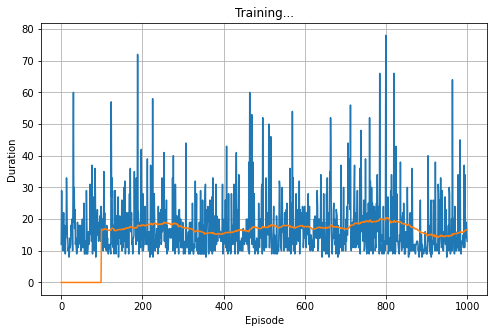

In [171]:
figsize(8,5)
plot_durations()

In [183]:
policy_net(memory.sample(1)[0].state)

tensor([93.3128, 93.3032], grad_fn=<AddBackward0>)

In [184]:
memory.sample(1)[0].state

tensor([-0.0841, -0.1875,  0.0749,  0.3489])